Nonlinear feedforward+feedback guidance for SRP applications

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn 

plt.style.use('seaborn-whitegrid')

# from Utils.gpops import srp as srp_opt
from Utils.RK4 import RK4, Euler
from EntryGuidance.TrajPlot import TrajPlot

array([ 0.00380921, -0.59566304])

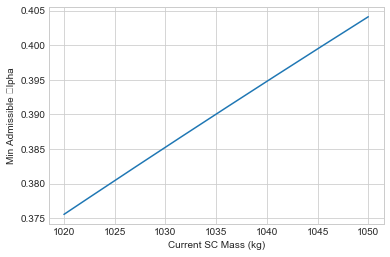

In [265]:
g0 = 1.62 * 1000/4000
mdry = 1020
m = np.linspace(1050, mdry, 500)

# g1 = 1.1 * 1000/1050
g1 = 1.1 * 1000/m
g2 = 1.1 * 1000/mdry
# g2 = 1.1 * 1000/950
# G = 0.5*(g1+g2)
G = g2
alpha_min = (g0+g2-g1)/G
plt.plot(m, alpha_min)
plt.xlabel("Current SC Mass (kg)")
plt.ylabel("Min Admissible \alpha")

np.polyfit(m/4, alpha_min, 1)

In [204]:
rho = 1
alpha = 0.42
eps_max = 4*(1-alpha)/alpha - rho
eps_min = 4*alpha/(1-alpha) - rho
print((eps_min,eps_max)) #2.7-6 for rho=0, alpha=0.4

(1.8965517241379306, 4.523809523809525)


In [172]:
mu/R**2

1.6178669184452057

Time of flight = 24.46 s
Final altitude = -0.335 m
Final velocity = 0.615 m/s
Fuel consumed = 68.2 kg
Objective = 36.9


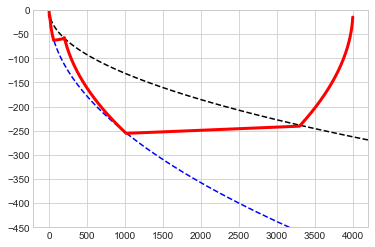

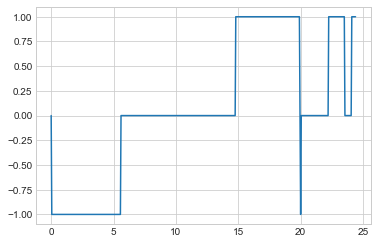

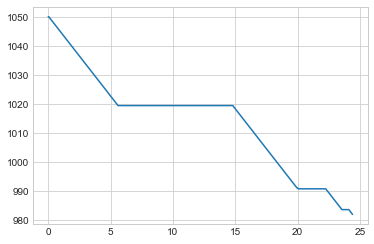

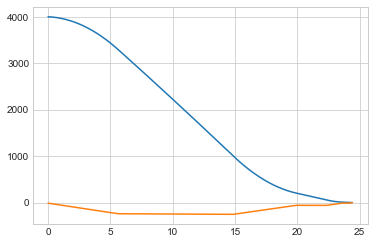

In [274]:
# reference "Quasi Time Fuel Optimal Feedback Control of Perturbed Double Integrator"
# Recreating the example from the paper 

p = 40000.

R = 1.738e6
k = 5.5 
mu = 4.887e12


x0 = [4000, -15, 1050] # pos vel mass 

def dyn(x, t,):
    M = x[2]
    c = 1000/p
#     c = M/p
    u = controller_mfc(x*c,)
    dv = ( ((p+1*400*np.exp(-0.02*t))/M)*u - mu/(x[0] + R)**2 )
    
    dM = -k*np.abs(u)
    if np.abs(x[0]) + np.abs(x[1]) < 1:
        return 0,0,0
    else:
        return x[1], dv, dM
    

def controller_mfc(x, ):
    
    delta = 100 #small factor to check for zero
    def near_zero(z):
        return np.abs(x)[0] <= delta
        
    x1, x2, m = x
    
        
    rho = 0 # time weighting factor, 0 for fuel optimality 
    adaptive = False
    # for pure double integrator, F = 0, G1=G=G2=1
    # alpha < 0.5
    if adaptive:
#         coeff = np.array([ 0.00380573, -0.55245659]) # mdry = 950
        coeff = np.array([ 0.00380921, -0.59566304]) # mdry = 1020
        alpha = np.polyval(coeff, m)+ 0.05
        eps_max = 4*(1-alpha)/alpha - rho
        eps_min = 4*alpha/(1-alpha) - rho
        eps = min(eps_min + 0.1, eps_max)
#         print((alpha, eps))
    else:
        alpha = 0.2
#         eps = 1.9 
        eps_max = 4*(1-alpha)/alpha - rho
        eps_min = 4*alpha/(1-alpha) - rho
        eps = min(eps_min + 0.1, eps_max)
#         print(eps)

#     assert eps > eps_min and eps < eps_max, "Invalid choice of epsilon"
    
#     x1 -= 10/4. # Aims for 10 m above the ground 
    S1 = x1 + x2*np.abs(x2)*(4+rho+eps)/(2*(rho+eps))
    S2 = x1 + x2*np.abs(x2)*0.5/(1-alpha)
    S = S1*S2

    # Initialize the memory
    try:
        controller_mfc.u_prev 
    except:
        if not near_zero(S):
            u = -np.sign(np.sign(S1) + np.sign(S2))
        else:
            if np.abs(S1) < np.abs(S2):
                u = 0
            else:
                u = -np.sign(x2)
        controller_mfc.u_prev = u
#         print("Initialized u = {}".format(u))
        controller_mfc.S_history = [S]
        controller_mfc.S1_last = S1

        controller_mfc.u_history = [u]
        return u
   
    if S*controller_mfc.S_history[-1] < 0: # Have to update the memory for either branch here
        if S1*controller_mfc.S1_last < 0:
            u = 0
        else:
            u = -np.sign(x2)
        controller_mfc.u_prev = u
    else:
        if S < 0:
            u = controller_mfc.u_prev 

        else:
            u = -np.sign(np.sign(S1) + np.sign(S2))
    
    controller_mfc.S1_last = S1

    controller_mfc.S_history.append(S)
#     if np.max(np.abs(controller_mfc.u_history)) > 0:
#         u = np.clip(u, 0.3, 1)
    controller_mfc.u_history.append(u)    
    return u
    
def plotS(alpha=0.2, rho=0,eps=1.1):
    c = 1000/p
    x1 = np.linspace(0, 4200, 500)
    x2 = np.linspace(0, -450, 400)
    
    X1,X2 = np.meshgrid(x1*c, x2*c)
    
    S1 = X1 + (4+rho+eps)/(2*rho+2*eps)*X2*np.abs(X2)
    S2 = X1 + 1/(2-2*alpha)*X2*np.abs(X2)
    
    plt.contour(X1/c, X2/c, S1, 0, colors='k', linestyles='dashed')
    plt.contour(X1/c, X2/c, S2, 0, colors='b', linestyles='dashed')

    
tf = 100
t = np.linspace(0, tf, 2000)
x = Euler(dyn, x0, t, )

dx = np.linalg.norm(np.diff(x, axis=0), axis=1)

iterm = np.argmin(dx)

plotS()
plt.plot(x[:iterm,0], x[:iterm,1], 'r',linewidth=3)

plt.figure()
plt.plot(t[:iterm], controller_mfc.u_history[:iterm])

plt.figure()
plt.plot(t[:iterm], x[:iterm,2])

plt.figure()
plt.plot(t[:iterm], x[:iterm,:2])

print("Time of flight = {:.2f} s\nFinal altitude = {:.3f} m\nFinal velocity = {:.3f} m/s\nFuel consumed = {:.1f} kg".format(t[iterm],x[-1,0],x[-1,1],x0[2]-x[-1,2]))
J = np.sum(1+np.abs(controller_mfc.u_history[:iterm]))*t[1]
print("Objective = {:.1f}".format(J))

In [14]:
# reference "A Family of Global Stabilizers for Quasi-Optimal Control of Planar Linear Saturated Systems"
def dyn(x, t, controller):
    return x[1], controller(x)


# def controller_fuel(x,): # Quasi-fuel optimal control

def controller_time(x, k): # quasi time optimal
    u = -k*(x[0] + (x[1])*np.max([np.abs(x[1])/(2*k),2/np.sqrt(k)*np.ones_like(x[1])], axis=0))
    return np.clip(u, -1, 1)





0.0016515530318465309


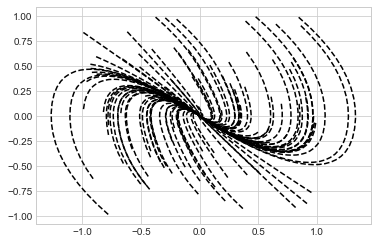

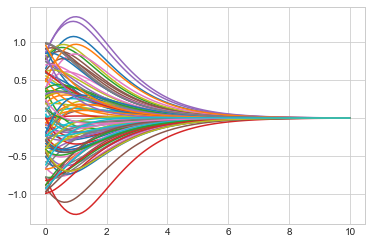

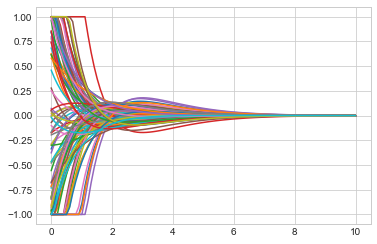

In [21]:
N = 100
x0 = -1 + 2*np.random.random((2, N))
tf = 10
t = np.linspace(0, tf, 100)
k = 1
x = RK4(dyn, x0, t, args=(lambda s: controller_time(s,k),))
u = [controller_time(xi, k) for xi in x]
print(np.max(x[-1]))

plt.plot(x[:,0], x[:,1], 'k--')
plt.figure()
plt.plot(t, x[:,0])
plt.figure()
plt.plot(t, u)
plt.show()

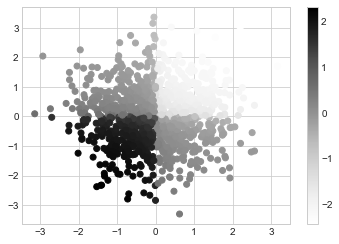

In [13]:
# Finite time stabilization of double integrator 
def dyn(x, t, alpha):
    return x[1], controller(x, alpha)
    
def signed_fractional_exponent(x, alpha):
    return np.sign(x)*np.abs(x)**alpha

def controller(x, alpha):
    return -signed_fractional_exponent(x[1], alpha) - signed_fractional_exponent(x[0], alpha/(2-alpha))

X = np.random.multivariate_normal([0,0], np.diag([1,1]), 1000)

u = [controller(x, 0.25) for x in X]

plt.scatter(X.T[0], X.T[1], c=u)
plt.colorbar()
plt.show()

0.04460718180532759


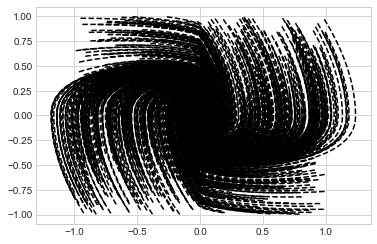

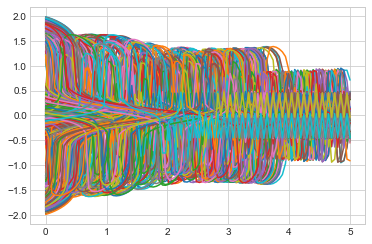

In [12]:
N = 1000
x0 = -1 + 2*np.random.random((2, N))
tf = 5
t = np.linspace(0, tf, 100)
alpha = 0.25
x = RK4(dyn, x0, t, args=(alpha,))
u = [controller(xi, alpha) for xi in x]
print(np.max(x[-1]))

plt.plot(x[:,0], x[:,1], 'k--')
# plt.figure()
# plt.plot(t, x)
plt.figure()
plt.plot(t, u)
plt.show()

Nominal trajectory design via optimal control

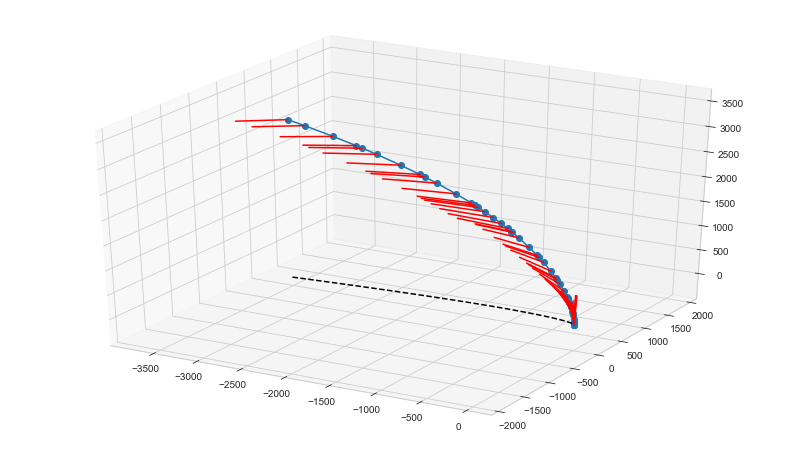

In [3]:
x0 = [-3200., 0., 3200., 625., 60., -270., 8500.]
traj = srp_opt((x0,))
# print((traj['time'][-1]))
u = np.array(traj['control']).T
plt.figure(1, figsize=(14,8))
TrajPlot(*(np.array(traj['state'])[:,0:3].T), T=(u[0]*u[1:4]).T/1000 , show=True, figNum=1)

Create a closed loop simulation from a given initial condition and for dispersed values of the model parameters

In [6]:
from scipy.interpolate import interp1d 

class SRPController:
    """ Manages the reference trajectory, gains, and differential states
    required to implement a nonlinear controller that is robust to uncertainty 
    """
    def __init__(self, reference, gains):
        u = np.array(reference['control']).T # Magnitude and unit vector representation         
        T = (u[0]*u[1:4]).T
        
        x = np.array(reference['state'])
        t = np.array(reference['time']).squeeze()
        
        self.reference_state = interp1d(t, x, axis=0, kind='cubic')
        self.reference_control = interp1d(t, T, axis=0, kind='cubic')
        self.gains = gains 
        
        self.gain_state = None
        self.gain_rate = None 
        self.gain_time = 0. 
        return 
        
        
    def controller(self, time, state, thrust_bounds):
        
        c, k, alpha, beta = self.gains # all gains could be a triple (per axis) but for now we'll assume scalars 
        
        ref_state = self.reference_state(time)
        ref_control = self.reference_control(time)
        if state.ndim>1:
            ref_state = ref_state[:,None]
            ref_control = ref_control[:,None]
            
        ds = ref_state - state
        e1 = ds[0:3]
        e1_dot = ds[3:6]
        e = e1 + c*e1_dot 
#         K = np.diag(k)
        
        if self.gain_state is None:
            self.gain_state = np.zeros_like(e)
            self.gain_rate = k*alpha*e + beta*np.sign(e)
            self.e0 = e 
        
        self.gain_rate = k*alpha*e + beta*np.sign(e) # This is the current gain_rate. 
#         self.gain_rate = 0.5*(self.gain_rate + k*alpha*e + beta*np.sign(e))  #We could also average it with the previous gain rate 
        self.gain_state += self.gain_rate * (time-self.gain_time)
        self.gain_time = time
    
        T = ref_control + k*(e-0*self.e0) + self.gain_state 
        
        # Clip the total magnitude to be within the bounds 
        Tmag = np.linalg.norm(T, axis=0)
        Tunit = T/Tmag 
        T = np.clip(Tmag, *thrust_bounds) * Tunit 
        return T

def dynamics( x, t, u, vei):
        
        p = x[0:3]
        v = x[3:6] 
        m = x[6]
        
        g = np.array([0, 0, 3.71])
        if x.ndim>1:
            g = g[:,None]
            
        dx = np.empty(x.shape, dtype=x.dtype)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -vei * (u[0]**2 + u[1]**2 + u[2]**2)**0.5   
        return dx
    
def simulation(x0, tf, controller, param=(1./(9.81*290), 40*8500., 70*8500.), cycle=1):
    vei, Tmin, Tmax = param # Inverse escape velocity, min thrust, max thrust 

#     cycle = 1 # seconds 
    tf_int = int(tf)
    t = np.linspace(0, tf_int, tf_int/cycle)
    t = np.append(t, tf)
    dt = np.diff(t)
    
    X = [x0]
    U = []
    for time, next_time in zip(t, t[1:]):
        u = controller(time, X[-1], (Tmin, Tmax))
        U.append(u)
        
        x = RK4(dynamics, X[-1], np.linspace(time, next_time, 10), args=(u, vei))
        X.append(x[-1])
        
    U.append(U[-1]) # So its the same length 
#     controller.gain_state = None # essentially resets the controller, allowing it to be used for another simulation without recreating 
    return t, np.array(X), np.array(U)
    
    
def plot(t, x, u, label=""):

        T = np.linalg.norm(u, axis=1)
    
        label = label
        
        plt.figure(1)
        plt.plot(t, x.T[-1], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        plt.legend()
        
        plt.figure(2)
        plt.plot(t, x.T[0:3].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        
        plt.figure(3)
        plt.plot(t, x.T[3:6].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        
        plt.figure(4)
        plt.plot(t, T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.legend()
        
#         plt.figure(5)
#         plt.plot(t, u, '--', label=label)
#         plt.xlabel('Time (s)')
#         plt.ylabel('Control Directions')
#         plt.legend()
        
        return
    


In [25]:
import chaospy as cp
x0 = [-3200., 0., 3200., 625., 0., -270., 8500.]
ux = cp.Uniform(x0[0]-400,x0[0]+400)
uy = cp.Uniform(x0[1]-1000,x0[1]+1000)
uz = cp.Uniform(x0[2]-600,x0[2]+800)
uu = cp.Uniform(x0[3]-40,x0[3]+100)
uv = cp.Uniform(x0[4]-100,x0[4]+100)
uw = cp.Uniform(x0[5]-40,x0[5]+40)
D = cp.J(ux,uy,uz,uu,uv,uw)

R = D.sample(1000, 'S')
print(R.shape)
X0 = np.append(R, x0[-1]*np.ones_like(R[:1]),axis=0)


tf = float(np.array(traj['time'])[-1])

print(X0.shape)
C = SRPController(traj, gains=[7.65193911e+00, 9.47145179e+03, 5.01265421e-01, 7.50637837e+03])

t,x,u = simulation(X0, tf, C.controller, cycle=0.1)

xf = x[-1]
pos_err = (np.linalg.norm(xf[0:3], axis=0))
vel_err = (np.linalg.norm(xf[3:6], axis=0))

print(t.shape)
print(x.shape)
print(u.shape)

(6, 1001)
(7, 1001)


E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(131,)
(131, 7, 1001)
(131, 3, 1001)


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 <a list of 10 Text yticklabel objects>)

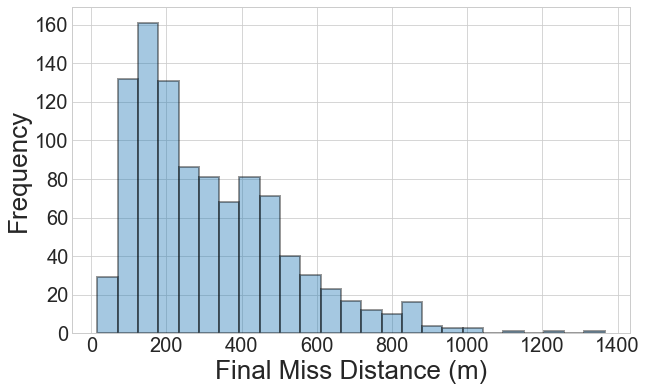

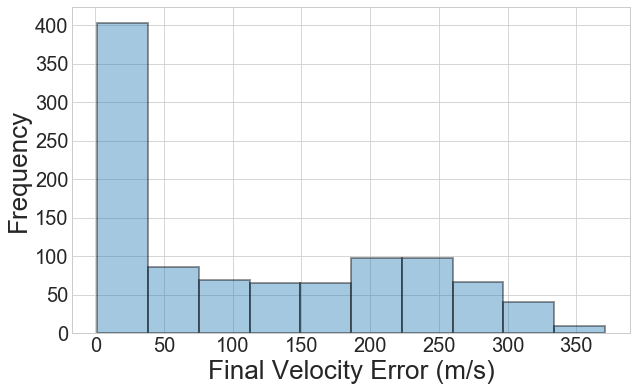

In [26]:
plt.figure()

plt.figure(figsize=(10,6))
seaborn.distplot(pos_err, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Final Miss Distance (m)',fontsize=26)
plt.ylabel('Frequency', fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.figure(figsize=(10,6))
seaborn.distplot(vel_err, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Final Velocity Error (m/s)',fontsize=26)
plt.ylabel('Frequency', fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ValueError: x and y must have same first dimension, but have shapes (131,) and (7, 131)

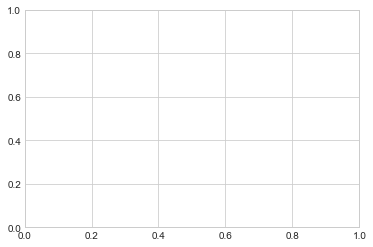

In [63]:
plot(t, x, u, label="Feedback")
plot(t, C.reference_state(t), C.reference_control(t), label="Ref")

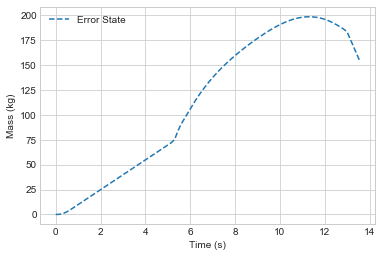

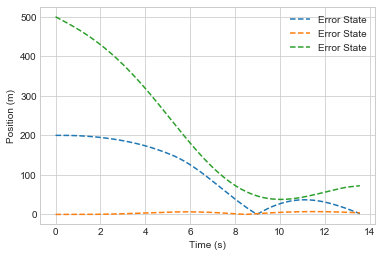

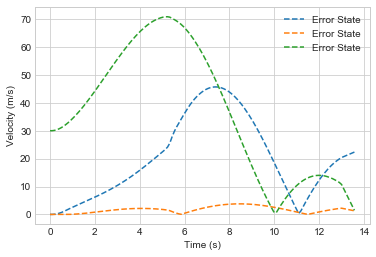

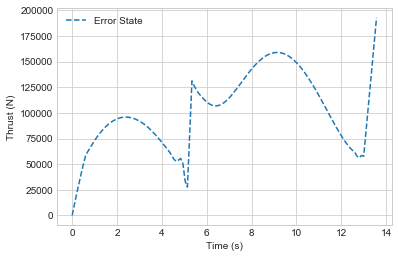

In [17]:
dx = np.abs(x - C.reference_state(t))
du = np.abs(u - C.reference_control(t))
plot(t, dx, du, label="Error State")


In [4]:
from scipy.optimize import differential_evolution

In [ ]:
import chaospy as cp
x0 =np.array([-3200., 0., 3200., 625., 0., -270., 8500.]) 
# ux = cp.Uniform(x0[0]-400,x0[0]+400)
# uy = cp.Uniform(x0[1]-100,x0[1]+100)
# uz = cp.Uniform(x0[2]-600,x0[2]+800)
# uu = cp.Uniform(x0[3]-40,x0[3]+10)
# uv = cp.Uniform(x0[4]-10,x0[4]+100)
# uw = cp.Uniform(x0[5]-40,x0[5]+40)
# D = cp.J(ux,uy,uz,uu,uv,uw)

# R = D.sample(1000, 'S')
# print(R.shape)
# X0 = np.append(R, x0[-1]*np.ones_like(R[:1]),axis=0)
P = np.diag([150,30,200, 10, 10, 10, 0.0001])**1
D = cp.MvNormal(x0, P)
X0 = D.sample(1000, 'S')

print(X0.T[0])
tf = float(np.array(traj['time'])[-1])

best = [ (np.zeros((4,)), 1e12) ]

def objective(c):
    C = SRPController(traj, gains=c)

    t,x,u = simulation(X0, tf, C.controller, cycle=0.1)

    xf = x[-1]
    pos_err = (np.linalg.norm(xf[0:3], axis=0))
    vel_err = (np.linalg.norm(xf[3:6], axis=0))
    
    J = np.linalg.norm(pos_err) + np.linalg.norm(vel_err)*10
    if J < best[-1][1]:
        best.append((c, J))
        print("Gains = {}".format(c))
        print("Cost = {}".format(J))
        print("Max dist error = {} m".format(pos_err.max()))
        print("Max vel  error = {} m/s \n".format(vel_err.max()))
    return J

sol = differential_evolution(objective, bounds=((0,300), (0, 1e4), (0.5, 5), (0, 1e4) ), polish=False, disp=True)

# Covariance Minimization

Begin with a scalar scenario $\dot{x} = ax + bu$ and thus $\dot{P} = 2(a+bk)P$

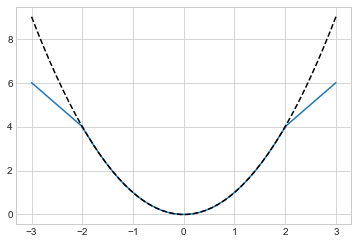

In [83]:
x = np.linspace(-3,3)
y = x*np.clip(x,-2,2)
plt.plot(x,y)
plt.plot(x, x**2, 'k--')

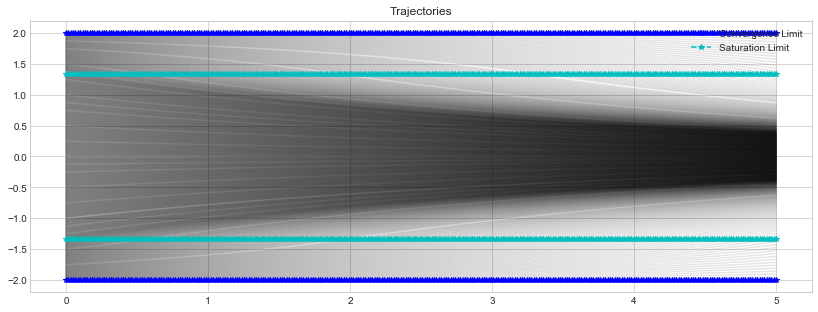

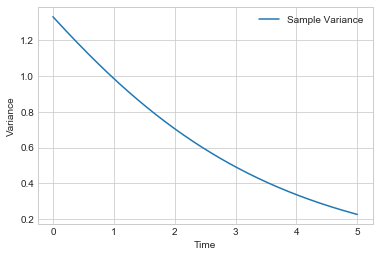

In [125]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
from scipy.interpolate import interp1d
from Utils.RK4 import RK4

D = cp.Uniform(-2,2)
# D = cp.Uniform(2, 2.5)
# X0 = cp.Normal(0,1).sample(2000, 'H')
X0 = D.sample(1000, 'M')
P0 = cp.Var(D)

def ufun(u, umax):
    return np.clip(u, -umax, umax)

def f(x, t, a, b, k, umax):
    return a*x + b*ufun(k*x, umax)

def fsat(x,y,a,b,umax):
    return a*x + b*np.sign(k*x)*umax

def cov(p, t, X, a, b, k, umax):
    x = X(t)
    xbar = np.mean(x)
    E = np.mean(x*ufun(k*x, umax))
    stuff = b*(E-k*xbar**2)
    return 2*a*p + 2*stuff

a,b,k,umax = 0.5,1,-0.75,1
t = np.linspace(0,5,300)
X = RK4(f, X0, t, args=(a,b,k,umax))
P = P0*np.exp(2*(a+b*k)*t) # Naive linear propagation - no saturation effects accounted for 
# Psat = RK4(cov, [P0], t, args=(interp1d(t,X,axis=0),a,b,k,umax))
Xf = X[-1]
stable = np.abs(Xf) <= np.abs(X0)
# print(X.shape)

plt.figure(figsize=(14,5))
plt.title("Trajectories")
try:
    plt.plot(t, X[:, stable], 'k', alpha=0.1)
except ZeroDivisionError:
    pass 

if not a==0:
    plt.plot(t, np.ones_like(t)*-b*umax/a,'b*--',label="Convergence Limit")
    plt.plot(t, np.ones_like(t)*b*umax/a, 'b*--')
plt.plot(t, np.ones_like(t)*umax/k, 'c*--', label='Saturation Limit')
plt.plot(t, np.ones_like(t)*-umax/k, 'c*--')

try:
    plt.plot(t, X[:, np.logical_not(stable)], 'r')
except ZeroDivisionError:
    pass 
plt.legend()

plt.figure()
plt.plot(t, np.var(X, axis=1), label="Sample Variance")
# plt.plot(t, P, 'k--', label="Integrated without saturation")
# plt.plot(t, Psat, label="Integrated with saturation")

plt.legend()
plt.ylabel("Variance")
plt.xlabel("Time")

plt.show()

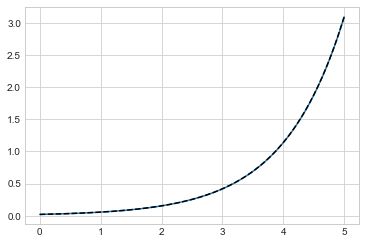

In [122]:
plt.plot(t, np.var(np.abs(X[:,np.logical_not(stable)]), axis=1))
plt.plot(t, np.exp(2*a*t)*0.5**2/12, 'k--')

In theory we know the probability that $x_0$ is within the convergence limits. So we can compute the covariance of points in side, the covariance of points outisde, and finally perform a weighted sum.

It only makes sense to focus on the subset you can control. I.e. for Gaussian inputs, a bounded subset is within the controllable set, neglect any trajectories outside controllability. 

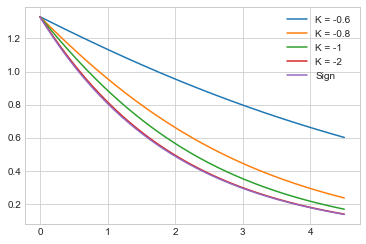

In [127]:
a,b,k,umax = 0.5,1,-0.6,1
plt.figure()

for k in [-0.6, -0.8, -1, -2]:

    t = np.linspace(0,4.5,300)
    X = RK4(f, X0, t, args=(a,b,k,umax))

    plt.plot(t, np.var(X, axis=1), label="K = {}".format(k))
X = RK4(fsat, X0, t, args=(a,b,umax))
plt.plot(t, np.var(X, axis=1), label="Sign")

plt.legend()

In [ ]:
# Even for just this scalar linear system, we can we use DA to expand the state as a function of x0? to accurately estimate P

In [1]:
import sympy as sym

ModuleNotFoundError: No module named 'sympy'

In [3]:
x = sym.var('x')
n = sym.var('n')

In [11]:
y1 = 1 - 2*(x-x**2)**0.5 
y2 = (1+n*x**2)**0.5 - 1
z = y1**2 - y2**2

In [12]:
print(z.simplify())

(2*(x*(-x + 1))**0.5 - 1)**2 - ((n*x**2 + 1)**0.5 - 1)**2


In [19]:
M = np.diag([1,-4,2])
np.linalg.pinv([[3]])

array([[0.33333333]])

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn 

In [20]:
n = 3
P = np.random.random((n,n))
P = P + P.T

def CoeffMatrix(P):
    n = np.asarray(P).shape[0]
    I = np.eye(n)
    r = np.arange(n)
    C = np.zeros((n**2, n**2))
    
    for i in r:
        rows = r + i*n 
        Z = np.zeros((n, n*i))
        D = P[i,i]*I 
        V = []
        
        for j in range(i+1, n):
            V.append(2*P[i,j]*I)
        if V:
            V = np.hstack(V)
            row = np.hstack((Z,D,V))
        else:
            row = np.hstack((Z,D))
        C[rows] = row 
        
    return C

C = CoeffMatrix(P)

# Verify that it works properly...
S = np.random.random((n,n))
Sv = np.reshape(S.T, -1)
Pf = S.dot(P).dot(S.T)
T = np.trace(Pf)
T2 = Sv.dot(C.T).dot(Sv)
print(T-T2) # = 0 

8.881784197e-16


In [16]:
S

array([[ 0.39643649,  0.44691478,  0.57701299],
       [ 0.12267901,  0.96184243,  0.63071815],
       [ 0.51375965,  0.36309872,  0.47645006]])